## Harmful Brain Activity Classification Competition
### Data Exploration

The dataset for "HMS - Harmful Brain Activity Classification" is quite confusing. The metadata file `train.csv` has 106,800 entries with:
- Unique `eeg_ids` = 17,089
- Unique `spectrogram_ids` = 11,138
- Unique `patients` = 1,950

In this notebook I will have a look at some of the data to try to figure out what is going on.

***EEG electrode names, positions and chains***
<div>
    <img src="https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/montage.png" width="500"/>
</div>

In [160]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import librosa
from librosa import feature as f

In [147]:
# helper functions to count the number of files of each type in the /kaggle/input/... filestructure

def count_files_and_types(directory):
    file_counts = defaultdict(lambda: defaultdict(int))
    for root, _, files in os.walk(directory):
        for file in files:
            extension = os.path.splitext(file)[1]
            file_counts[root][extension] += 1
    return file_counts

def print_file_counts(file_counts=None, directory=None):
    if file_counts is None:
        directory = 'data'
        file_counts = count_files_and_types(directory)
    
    for folder, file_type in file_counts.items():
        print(f'Folder: {folder}')
        for file_type, count in file_type.items():
            print(f'    {file_type if file_type else "No Extension"}: {count}')
            
    return file_counts

In [148]:
directory = 'data'
# file_counts = count_files_and_types(directory)
file_info = print_file_counts()

Folder: data
    No Extension: 1
Folder: data/hms-harmful-brain-activity-classification
    No Extension: 1
    .csv: 3
Folder: data/hms-harmful-brain-activity-classification/test_spectrograms
    .parquet: 1
Folder: data/hms-harmful-brain-activity-classification/train_eegs
    .parquet: 17300
Folder: data/hms-harmful-brain-activity-classification/train_spectrograms
    .parquet: 11138
Folder: data/hms-harmful-brain-activity-classification/test_eegs
    .parquet: 1
Folder: data/hms-harmful-brain-activity-classification/example_figures
    .pdf: 20
Folder: data/brain-spectrograms
    .pqt: 1
    .npy: 1


This notebooke makes use of three different datasets:
- hms-harmful-brain-activity-classification (Original competition dataset)
- brain-spegrograms (pre-processed spectrograms from original eeg data, provided by Chris Deotte)
- brain-eeg-spectrograms (pre-processed spectrograms and eegs from original eeg data, provided by Chris Deotte)

In [136]:
for key in file_counts.keys():
    print(key)

data
data/hms-harmful-brain-activity-classification
data/hms-harmful-brain-activity-classification/test_spectrograms
data/hms-harmful-brain-activity-classification/train_eegs
data/hms-harmful-brain-activity-classification/train_spectrograms
data/hms-harmful-brain-activity-classification/test_eegs
data/hms-harmful-brain-activity-classification/example_figures
data/brain-spectrograms


## Exploring original data

In [151]:
train_path = os.path.join('.',
                          'data',
                          'hms-harmful-brain-activity-classification',
                          'train.csv')
train_eegs_path = os.path.join('.',
                          'data',
                          'hms-harmful-brain-activity-classification',
                          'train_eegs')
train_spectrograms_path = os.path.join('.',
                          'data',
                          'hms-harmful-brain-activity-classification',
                          'train_spectrograms')

train = pd.read_csv(train_path)

print('Train shape', train.shape )
train.head(5)

Train shape (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


<Axes: >

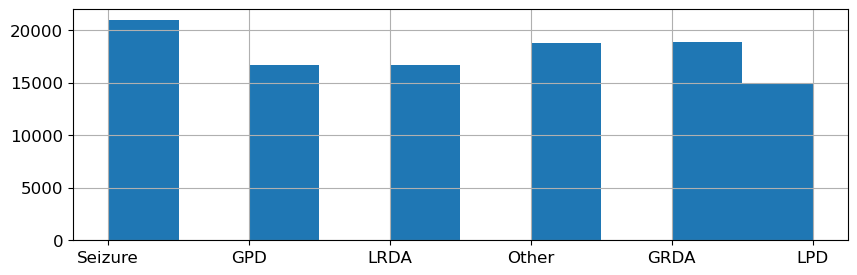

In [153]:
plt.figure(figsize=(10,3))
train['expert_consensus'].hist()

In [155]:
train.describe()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000
mean,2.104387e+09,26.286189,118.817228,1.067262e+09,43.733596,520.431404,2.141415e+09,32304.428493,0.878024,1.138783,1.264925,0.948296,1.059185,1.966283
std,1.233371e+09,69.757658,314.557803,6.291475e+08,104.292116,1449.759868,1.241670e+09,18538.196252,1.538873,2.818845,3.131889,2.136799,2.228492,3.621180
min,5.686570e+05,0.000000,0.000000,3.537330e+05,0.000000,0.000000,3.380000e+02,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.026896e+09,1.000000,6.000000,5.238626e+08,2.000000,12.000000,1.067419e+09,16707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.071326e+09,5.000000,26.000000,1.057904e+09,8.000000,62.000000,2.138332e+09,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.172787e+09,16.000000,82.000000,1.623195e+09,29.000000,394.000000,3.217816e+09,48036.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000
max,4.294958e+09,742.000000,3372.000000,2.147388e+09,1021.000000,17632.000000,4.294934e+09,65494.000000,19.000000,18.000000,16.000000,15.000000,15.000000,25.000000


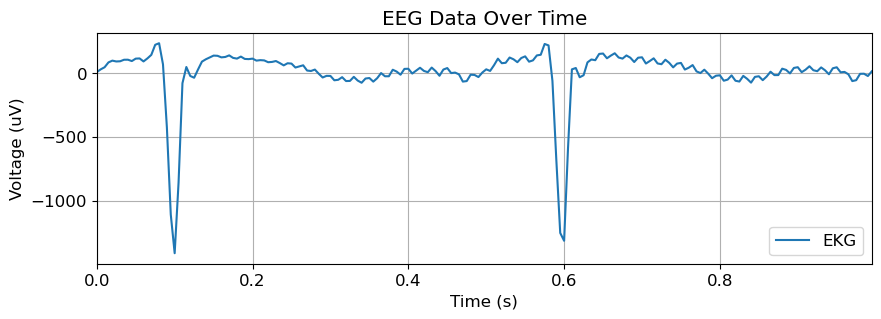

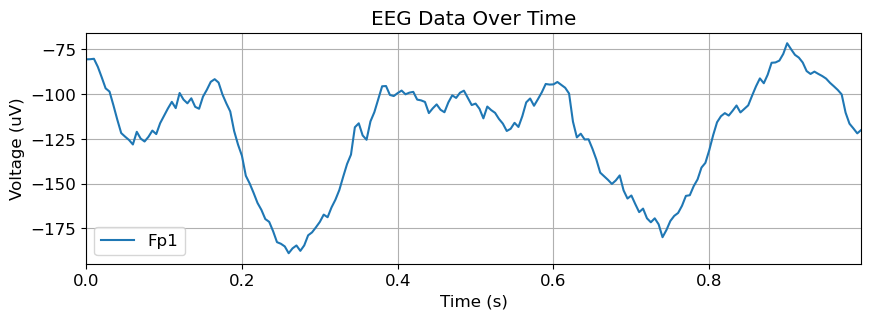

In [156]:
def get_single_eeg(train=train, row=0):
    eeg_id = train.iloc[row].eeg_id
    data_path = os.path.join(train_eegs_path, str(eeg_id) + '.parquet')
    return pd.read_parquet(data_path), train.iloc[row]

def plot_single_electrode(eeg, electrode=None, roi_start=None, roi_end=None):
    allowed_electrodes = {'Fp1', 'F3', 'C3', 'P3', 'F7',
                          'T3', 'T5', 'O1', 'Fz', 'Cz',
                          'Pz', 'Fp2', 'F4', 'C4', 'P4',
                          'F8', 'T4', 'T6', 'O2', 'EKG'}
    sampling_rate = 200
    
    if electrode is None or electrode not in allowed_electrodes: electrode = 'Fp1'
    
    if roi_start is None: start = 0
    else: start = roi_start * sampling_rate
    
    if roi_end is None: end = len(eeg.index)
    else: end = roi_end * sampling_rate

    data = eeg.index, eeg[electrode]
    data = data[0][start:end], data[1][start:end]
        
    plt.figure(figsize=(10,3))
    plt.plot(data[0]/200, data[1], label=electrode)

    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (uV)')
    plt.xlim((min(data[0]/200), max(data[0]/200)))
    plt.title('EEG Data Over Time')
    plt.legend()
    plt.grid()
    plt.show()
    return data

eeg, row = get_single_eeg(train)
data = plot_single_electrode(eeg, electrode='EKG', roi_end=1)
data = plot_single_electrode(eeg, electrode='Fp1', roi_end=1)

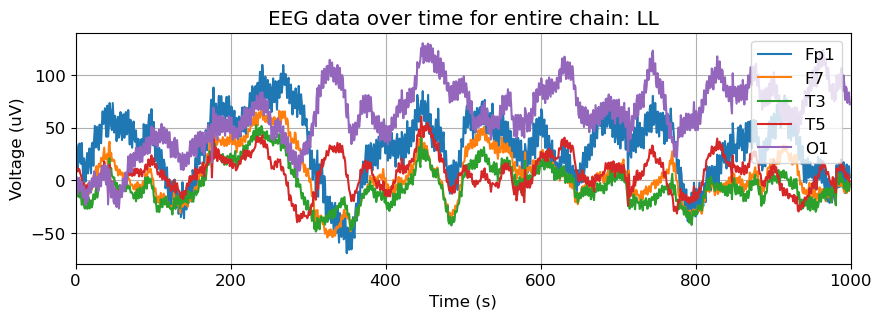

In [157]:
def plot_multiple_electrodes(eeg, chain='LL', roi_start=None, roi_end=None):
    sampling_rate = 200
    chains = {'LL': ('Fp1', 'F7', 'T3', 'T5', 'O1'),
              'LP': ('Fp1','F3','C3','P3','O1'),
              'RP': ('Fp2','F8','T4','T6','O2'),
              'RR': ('Fp2','F4','C4','P4','O2')}
    electrodes = chains[chain]
    
    if roi_start is None: start = 0
    else: start = roi_start * sampling_rate
    
    if roi_end is None: end = len(eeg.index)
    else: end = roi_end * sampling_rate

    if start >= len(eeg.index) or end >= len(eeg.index):
        print('Region of interest must start and end within time window of measurement')
        print(f'roi_start: {start}')
        print(f'roi_end: {end}')
        print(f'Length of sample: {len(eeg.index  * sampling_rate)}')
        return

    plt.figure(figsize=(10, 3))
    for e in electrodes:
        plt.plot(eeg.index[start:end], eeg[e][start:end], label=e)
        plt.xlim((start, end))
        plt.legend(loc='upper right')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (uV)')
        plt.title(f'EEG data over time for entire chain: {chain}')
        plt.grid()
    plt.show()
        
eeg, row = get_single_eeg(train, row=1000)
plot_multiple_electrodes(eeg, chain='LL', roi_end=5)
# plot_multiple_electrodes(eeg, chain='LP', roi_end=5)
# plot_multiple_electrodes(eeg, chain='RP', roi_end=5)
# plot_multiple_electrodes(eeg, chain='RR', roi_end=5)

In [158]:
# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

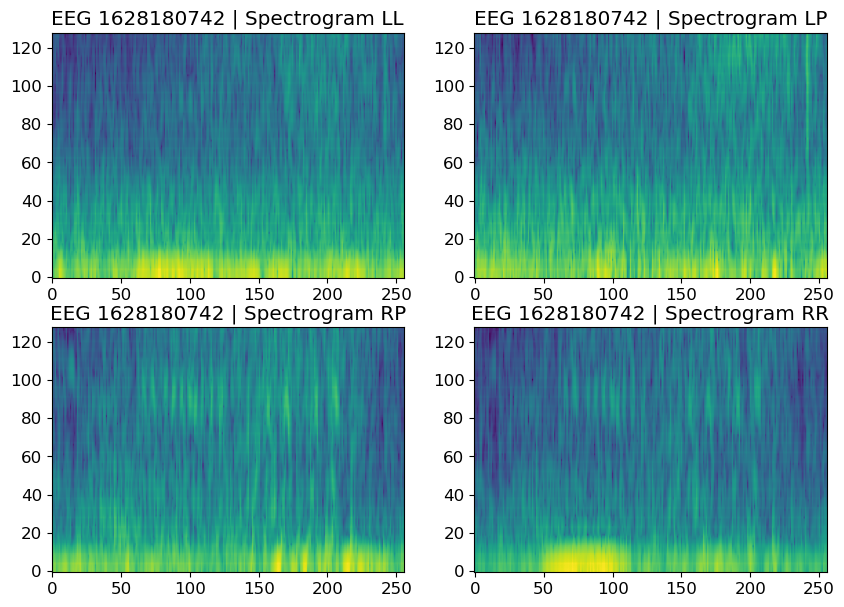

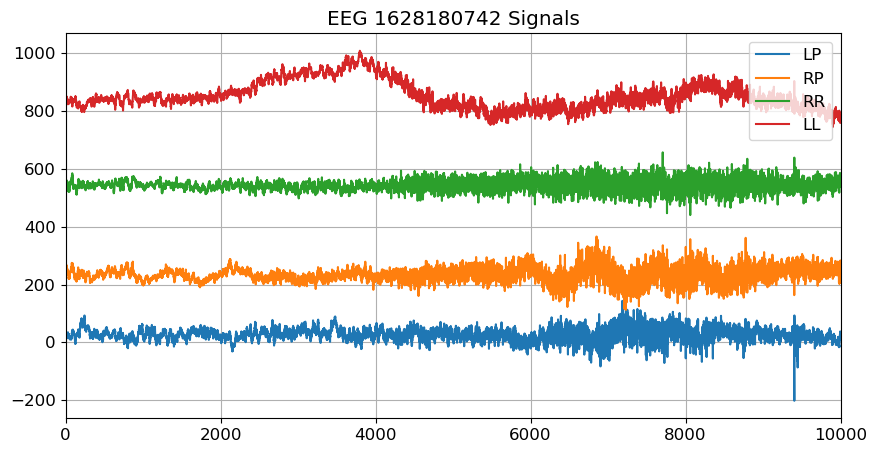


#########################



In [159]:
eeg, row = get_single_eeg(train, row=0,)

chains = {'LL': ('Fp1', 'F7', 'T3', 'T5', 'O1'),
          'LP': ('Fp1','F3','C3','P3','O1'),
          'RP': ('Fp2','F8','T4','T6','O2'),
          'RR': ('Fp2','F4','C4','P4','O2')}

middle = (len(eeg)-10_000)//2
eeg = eeg.iloc[middle:middle+10_000]
img = np.zeros((2**7, 2**8, 2**2), dtype='float32')

plt.figure(figsize=(10,7))

signals = []
names = ('LL', 'LP', 'RP', 'RR')
for i in range(4):
    chain = chains[names[i]]
    for j in range(4):

        # compute electrode pair differences
        x = eeg[chain[j]].values - eeg[chain[j+1]].values

        # fill in nan values
        m = np.nanmean(x)
        if np.isnan(x).mean() < 1:
            x = np.nan_to_num(x, nan=m)
        else:
            x[:] = 0

        # DENOISE
        USE_WAVELET = None #or "db8" or anything below
        if USE_WAVELET:
            x = denoise(x, wavelet=USE_WAVELET)
        signals.append(x)

        mel_spec = librosa.feature.melspectrogram(y=x,
                                    sr=200,
                                    hop_length=len(x)//256, 
                                    n_fft=1024,
                                    n_mels=128,
                                    fmin=0,
                                    fmax=20,
                                    win_length=128)
        
        width = (mel_spec.shape[1]//32)*32
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

        # STANDARDIZE TO -1 TO 1
        mel_spec_db = (mel_spec_db+40)/40 
        img[:,:,i] += mel_spec_db
                
    # AVERAGE THE 4 MONTAGE DIFFERENCES
    img[:,:,i] /=  4.0

    display = True
    if display:
        plt.subplot(2,2,i+1)
        plt.imshow(img[:,:,i],aspect='auto',origin='lower')
        plt.title(f'EEG {row.eeg_id} | Spectrogram {names[i]}')
        
if display: 
    plt.show()
    plt.figure(figsize=(10,5))
    offset = 0
    for k in range(4):
        if k>0: offset -= signals[3-k].min()
        plt.plot(range(10_000),signals[k]+offset, label=names[k-3])
        offset += signals[3-k].max()
    plt.xlim((0,10_000))
    plt.legend()
    plt.title(f'EEG {row.eeg_id} Signals')
    plt.grid()
    plt.show()
    print(); print('#'*25); print()